# Capstone Project : Aplikasi Deteksi Dini Kondisi Tanaman Tomat Untuk Sistem Pertanian Berkelanjutan

## Team ID : CC25-CF274

Team Member :    
- MC013D5Y0998 - Wayan Ardike
- MC281D5Y1293 - Josua Sianturi
- MC295D5Y1802 - Haekal Hasan Thanvindra
- FC796D5X0088 - Heni Melita Ulfianah
- FC796D5X0089 - Diajeng Salwa Aulan Ni'Mah
- FC796D5X0090 - Fitrohtun Nisha

### **Objective:**
Membangun sebuah model klasifikasi citra berbasis transfer learning dengan arsitektur MobileNetV2 untuk mendeteksi dan mengklasifikasikan jenis penyakit pada tanaman tomat dari citra daun ke dalam sebelas kategori:

1. Bacterial Spot  
2. Early Blight  
3. Late Blight  
4. Leaf Mold  
5. Septoria Leaf Spot  
6. Spider Mites (Two-Spotted Spider Mite)  
7. Target Spot  
8. Tomato Mosaic Virus  
9. Tomato Yellow Leaf Curl Virus  
10. Powdery Mildew  
11. Healthy (Tanpa Penyakit)


### **Sumber Dataset**
https://www.kaggle.com/datasets/ashishmotwani/tomato

## **Import Semua Packages/Library yang Digunakan**

Mengimpor berbagai library yang dibutuhkan untuk menjalankan seluruh tahapan dalam proyek, mulai dari pemrosesan data hingga pelatihan dan evaluasi model

In [9]:
# 1. Impor libraries umum yang sering digunakan
import os
import shutil
import random
from random import sample
import pathlib
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# 2. Impor libraries untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# 3. Impor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize, rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# 4. Impor libraries untuk pembuatan dan evaluasi model
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
import matplotlib.image as mpimg
from google.colab import files


# 5. Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [ ]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.19.0


## **Data Preparation**

Pada tahap ini, dataset gambar daun tomat yang terdiri atas berbagai jenis penyakit diunduh dari Kaggle. Selanjutnya dataset diekstrak ke dalam direktori `dataset/` yang berisi dua subfolder utama: `train` dan `valid`. Masing-masing folder menyimpan gambar yang sudah diklasifikasikan berdasarkan nama kelasnya. Kemudian, dilakukan pengecekan jumlah gambar per kelas untuk masing-masing subset data, dan divisualisasikan menggunakan grafik batang. Ini bertujuan untuk memastikan distribusi kelas yang seimbang atau mengetahui jika terdapat ketidakseimbangan dalam jumlah data antar kelas.


### **Data Loading**

Train class distribution:
Bacterial_spot: 2826
Early_blight: 2455
healthy: 3051
Late_blight: 3113
Leaf_Mold: 2754
powdery_mildew: 1004
Septoria_leaf_spot: 2882
Spider_mites Two-spotted_spider_mite: 1747
Target_Spot: 1827
Tomato_mosaic_virus: 2153
Tomato_Yellow_Leaf_Curl_Virus: 2039

Validation class distribution:
Bacterial_spot: 549
Early_blight: 482
healthy: 603
Late_blight: 594
Leaf_Mold: 554
powdery_mildew: 189
Septoria_leaf_spot: 559
Spider_mites Two-spotted_spider_mite: 326
Target_Spot: 342
Tomato_mosaic_virus: 438
Tomato_Yellow_Leaf_Curl_Virus: 373


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17744\2610654577.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17744\2610654577.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(


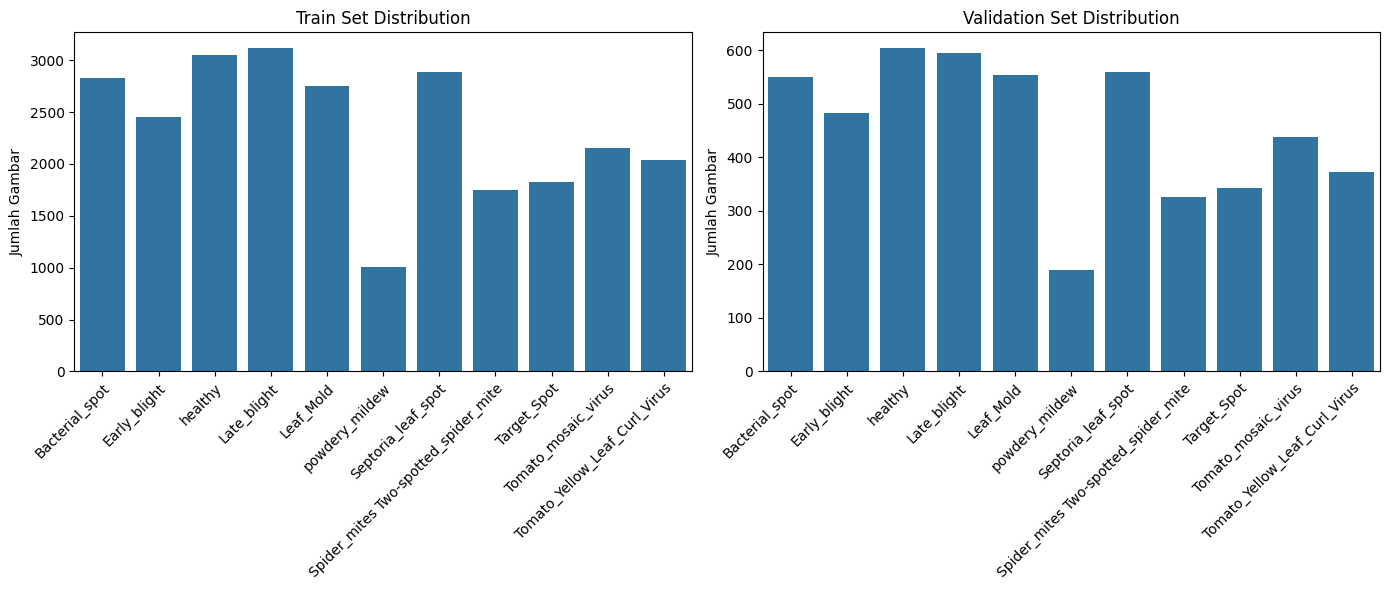

In [ ]:
# Path ke dataset
train_dir = "dataset/train"
valid_dir = "dataset/valid"

# Cek jumlah gambar per kelas di train
train_counts = {
    class_name: len(os.listdir(os.path.join(train_dir, class_name)))
    for class_name in os.listdir(train_dir)
}

# Cek jumlah gambar per kelas di valid
valid_counts = {
    class_name: len(os.listdir(os.path.join(valid_dir, class_name)))
    for class_name in os.listdir(valid_dir)
}

print("Train class distribution:")
for class_name, count in train_counts.items():
    print(f"{class_name}: {count}")

print("\nValidation class distribution:")
for class_name, count in valid_counts.items():
    print(f"{class_name}: {count}")

# Visualisasi distribusi kelas
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), ax=ax[0])
ax[0].set_title('Train Set Distribution')
ax[0].set_ylabel('Jumlah Gambar')
ax[0].set_xticklabels(
    ax[0].get_xticklabels(),
    rotation=45,
    ha='right',
    rotation_mode='anchor'
)

sns.barplot(x=list(valid_counts.keys()), y=list(valid_counts.values()), ax=ax[1])
ax[1].set_title('Validation Set Distribution')
ax[1].set_ylabel('Jumlah Gambar')
ax[1].set_xticklabels(
    ax[1].get_xticklabels(),
    rotation=45,
    ha='right',
    rotation_mode='anchor'
)

plt.tight_layout()
plt.show()

## **Data Preprocessing**

### **Split Dataset**

Pada tahap ini, sebagian data dari folder `valid` dipindahkan ke folder `test` untuk digunakan sebagai data uji. Proporsi data yang dipindahkan adalah 25%, menggunakan fungsi `train_test_split` dengan `random_state` agar hasil pembagian tetap konsisten. Proses ini memastikan bahwa kita memiliki tiga subset data: `train`, `valid`, dan `test`, yang masing-masing digunakan untuk pelatihan, validasi selama pelatihan, dan evaluasi akhir.

In [ ]:
valid_dir = 'dataset/valid'
test_dir = 'dataset/test'
split_ratio = 0.25  # ambil 20% dari valid jadi test

os.makedirs(test_dir, exist_ok=True)

for class_name in os.listdir(valid_dir):
    class_path = os.path.join(valid_dir, class_name)
    images = os.listdir(class_path)

    # Pisah 20% ke test
    _, test_images = train_test_split(images, test_size=split_ratio, random_state=42)

    # Buat folder tujuan
    test_class_path = os.path.join(test_dir, class_name)
    os.makedirs(test_class_path, exist_ok=True)

    # Pindahkan file
    for img in test_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(test_class_path, img)
        shutil.move(src, dst)

print("✅ Test set created successfully.")

✅ Test set created successfully.


### **ImageDataGenerator**

Setelah dataset dibagi, kita menggunakan `ImageDataGenerator` dari Keras untuk melakukan augmentasi data pada subset `train` agar model lebih robust terhadap variasi gambar. Augmentasi meliputi rotasi, pergeseran, zoom, shear, dan flip horizontal. Sementara itu, subset `valid` dan `test` hanya dinormalisasi (rescale) untuk menjaga integritas data saat evaluasi. Generator ini akan secara otomatis membaca gambar dari struktur folder dan menyiapkannya dalam bentuk batch yang siap digunakan oleh model.

In [ ]:
img_size = (224, 224)
batch_size = 32

train_dir = 'dataset/train'
valid_dir = 'dataset/valid'
test_dir  = 'dataset/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # penting untuk evaluasi akurat
)

Found 25851 images belonging to 11 classes.
Found 5009 images belonging to 11 classes.
Found 1674 images belonging to 11 classes.


## **Modelling**

Pada tahap ini, kami membangun model klasifikasi menggunakan arsitektur MobileNetV2 sebagai *feature extractor* (basis model). Model pre-trained ini dimuat dengan bobot dari `ImageNet` dan lapisan atasnya dihapus (`include_top=False`) agar dapat ditambahkan classifier khusus untuk mendeteksi penyakit daun tomat.

### Arsitektur Model
- Lapisan akhir dari MobileNetV2 dihubungkan ke lapisan GlobalAveragePooling2D untuk meratakan fitur.
- Kemudian ditambahkan dua lapisan Dropout dan Dense untuk mencegah overfitting dan membuat klasifikasi akhir.
- Output layer menggunakan fungsi aktivasi softmax sesuai dengan jumlah kelas.

In [ ]:
# Model base
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze awal

# Classifier custom
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,423,371 (9.24 MB)

 Trainable params: 165,387 (646.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Training Awal
Model dikompilasi dengan optimizer Adam dan fungsi loss categorical crossentropy. Pada tahap awal, semua lapisan MobileNetV2 dibekukan agar hanya classifier yang dilatih terlebih dahulu. Proses pelatihan menggunakan callback `EarlyStopping`, `ReduceLROnPlateau`, dan `ModelCheckpoint` untuk mengatur pembelajaran secara dinamis dan menyimpan model terbaik.

In [ ]:
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(factor=0.5, patience=2, verbose=1),
    ModelCheckpoint('best_model.h5', save_best_only=True, verbose=1)
]

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=callbacks
)

C:\Users\Lenovo\anaconda3\envs\tfenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.2666 - loss: 2.1874
Epoch 1: val_loss improved from inf to 1.13755, saving model to best_model.h5


808/808 ━━━━━━━━━━━━━━━━━━━━ 512s 628ms/step - accuracy: 0.2668 - loss: 2.1870 - val_accuracy: 0.6353 - val_loss: 1.1375 - learning_rate: 1.0000e-04
Epoch 2/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.5487 - loss: 1.3153
Epoch 2: val_loss improved from 1.13755 to 0.91244, saving model to best_model.h5


808/808 ━━━━━━━━━━━━━━━━━━━━ 462s 572ms/step - accuracy: 0.5487 - loss: 1.3152 - val_accuracy: 0.7021 - val_loss: 0.9124 - learning_rate: 1.0000e-04
Epoch 3/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.6147 - loss: 1.1137
Epoch 3: val_loss improved from 0.91244 to 0.80450, saving model to best_model.h5


808/808 ━━━━━━━━━━━━━━━━━━━━ 475s 587ms/step - accuracy: 0.6147 - loss: 1.1137 - val_accuracy: 0.7381 - val_loss: 0.8045 - learning_rate: 1.0000e-04
Epoch 4/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.6568 - loss: 0.9958
Epoch 4: val_loss improved from 0.80450 to 0.71764, saving model to best_model.h5


808/808 ━━━━━━━━━━━━━━━━━━━━ 464s 575ms/step - accuracy: 0.6568 - loss: 0.9957 - val_accuracy: 0.7624 - val_loss: 0.7176 - learning_rate: 1.0000e-04
Epoch 5/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.6773 - loss: 0.9300
Epoch 5: val_loss improved from 0.71764 to 0.68213, saving model to best_model.h5


808/808 ━━━━━━━━━━━━━━━━━━━━ 455s 563ms/step - accuracy: 0.6773 - loss: 0.9300 - val_accuracy: 0.7776 - val_loss: 0.6821 - learning_rate: 1.0000e-04
Epoch 6/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.6983 - loss: 0.8686
Epoch 6: val_loss improved from 0.68213 to 0.64796, saving model to best_model.h5


808/808 ━━━━━━━━━━━━━━━━━━━━ 467s 578ms/step - accuracy: 0.6983 - loss: 0.8686 - val_accuracy: 0.7844 - val_loss: 0.6480 - learning_rate: 1.0000e-04
Epoch 7/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.7097 - loss: 0.8384
Epoch 7: val_loss improved from 0.64796 to 0.61760, saving model to best_model.h5


808/808 ━━━━━━━━━━━━━━━━━━━━ 495s 613ms/step - accuracy: 0.7097 - loss: 0.8383 - val_accuracy: 0.7948 - val_loss: 0.6176 - learning_rate: 1.0000e-04
Epoch 8/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.7147 - loss: 0.8030
Epoch 8: val_loss improved from 0.61760 to 0.58928, saving model to best_model.h5


808/808 ━━━━━━━━━━━━━━━━━━━━ 479s 592ms/step - accuracy: 0.7148 - loss: 0.8029 - val_accuracy: 0.8028 - val_loss: 0.5893 - learning_rate: 1.0000e-04
Epoch 9/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.7263 - loss: 0.7734
Epoch 9: val_loss improved from 0.58928 to 0.57341, saving model to best_model.h5


808/808 ━━━━━━━━━━━━━━━━━━━━ 465s 575ms/step - accuracy: 0.7263 - loss: 0.7734 - val_accuracy: 0.8123 - val_loss: 0.5734 - learning_rate: 1.0000e-04
Epoch 10/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.7381 - loss: 0.7568
Epoch 10: val_loss improved from 0.57341 to 0.54774, saving model to best_model.h5


808/808 ━━━━━━━━━━━━━━━━━━━━ 470s 582ms/step - accuracy: 0.7381 - loss: 0.7568 - val_accuracy: 0.8189 - val_loss: 0.5477 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 10.


### Fine-tuning
Setelah training awal selesai, model dilanjutkan dengan **fine-tuning** di mana sebagian besar lapisan MobileNetV2 di-*unfreeze* (kecuali sekitar 30 lapisan pertama). Model kemudian dilatih ulang dengan learning rate yang lebih kecil untuk menyempurnakan bobot pre-trained. Fine-tuning dilakukan dalam dua tahap dengan jumlah epoch terbatas untuk mencegah overfitting.

> Dengan pendekatan ini, kami memanfaatkan kekuatan transfer learning dari MobileNetV2 serta kemampuan generalisasi yang baik untuk mendeteksi berbagai jenis penyakit daun tomat.


In [ ]:
# Unfreeze sebagian layer akhir
base_model.trainable = True
for layer in base_model.layers[:-30]:  # freeze semua kecuali 30 terakhir
    layer.trainable = False

# Re-compile dengan learning rate kecil
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune 5 epoch
fine_tune_history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=5,
    callbacks=callbacks
)

Epoch 1/5
808/808 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.6240 - loss: 1.0875
Epoch 1: val_loss did not improve from 0.54774
808/808 ━━━━━━━━━━━━━━━━━━━━ 531s 644ms/step - accuracy: 0.6241 - loss: 1.0873 - val_accuracy: 0.7934 - val_loss: 0.5950 - learning_rate: 1.0000e-05
Epoch 2/5
808/808 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.7544 - loss: 0.7051
Epoch 2: val_loss improved from 0.54774 to 0.47418, saving model to best_model.h5


808/808 ━━━━━━━━━━━━━━━━━━━━ 498s 616ms/step - accuracy: 0.7544 - loss: 0.7050 - val_accuracy: 0.8345 - val_loss: 0.4742 - learning_rate: 1.0000e-05
Epoch 3/5
808/808 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.7826 - loss: 0.6225
Epoch 3: val_loss improved from 0.47418 to 0.40931, saving model to best_model.h5


808/808 ━━━━━━━━━━━━━━━━━━━━ 487s 603ms/step - accuracy: 0.7826 - loss: 0.6225 - val_accuracy: 0.8603 - val_loss: 0.4093 - learning_rate: 1.0000e-05
Epoch 4/5
808/808 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.8128 - loss: 0.5500
Epoch 4: val_loss improved from 0.40931 to 0.37708, saving model to best_model.h5


808/808 ━━━━━━━━━━━━━━━━━━━━ 501s 619ms/step - accuracy: 0.8128 - loss: 0.5500 - val_accuracy: 0.8702 - val_loss: 0.3771 - learning_rate: 1.0000e-05
Epoch 5/5
808/808 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.8200 - loss: 0.5083
Epoch 5: val_loss improved from 0.37708 to 0.34905, saving model to best_model.h5


808/808 ━━━━━━━━━━━━━━━━━━━━ 495s 613ms/step - accuracy: 0.8200 - loss: 0.5083 - val_accuracy: 0.8782 - val_loss: 0.3491 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 5.


In [ ]:
fine_tune_history_2 = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=5,  # atau 10
    callbacks=callbacks
)

Epoch 1/5
808/808 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.8383 - loss: 0.4694
Epoch 1: val_loss improved from 0.34905 to 0.34134, saving model to best_model.h5


808/808 ━━━━━━━━━━━━━━━━━━━━ 500s 618ms/step - accuracy: 0.8383 - loss: 0.4694 - val_accuracy: 0.8824 - val_loss: 0.3413 - learning_rate: 1.0000e-05
Epoch 2/5
808/808 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.8510 - loss: 0.4318
Epoch 2: val_loss improved from 0.34134 to 0.31196, saving model to best_model.h5


808/808 ━━━━━━━━━━━━━━━━━━━━ 492s 609ms/step - accuracy: 0.8510 - loss: 0.4318 - val_accuracy: 0.8942 - val_loss: 0.3120 - learning_rate: 1.0000e-05
Epoch 3/5
808/808 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.8543 - loss: 0.4160
Epoch 3: val_loss improved from 0.31196 to 0.30215, saving model to best_model.h5


808/808 ━━━━━━━━━━━━━━━━━━━━ 482s 596ms/step - accuracy: 0.8543 - loss: 0.4160 - val_accuracy: 0.8966 - val_loss: 0.3021 - learning_rate: 1.0000e-05
Epoch 4/5
808/808 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.8698 - loss: 0.3805
Epoch 4: val_loss improved from 0.30215 to 0.28476, saving model to best_model.h5


808/808 ━━━━━━━━━━━━━━━━━━━━ 506s 627ms/step - accuracy: 0.8698 - loss: 0.3805 - val_accuracy: 0.9006 - val_loss: 0.2848 - learning_rate: 1.0000e-05
Epoch 5/5
808/808 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.8725 - loss: 0.3657
Epoch 5: val_loss improved from 0.28476 to 0.27043, saving model to best_model.h5


808/808 ━━━━━━━━━━━━━━━━━━━━ 505s 625ms/step - accuracy: 0.8725 - loss: 0.3657 - val_accuracy: 0.9084 - val_loss: 0.2704 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 5.


## Evaluasi dan Visualisasi

Setelah model selesai dilatih dan di-*fine-tune*, dilakukan proses evaluasi performa model menggunakan data uji (test set). Evaluasi dilakukan melalui dua pendekatan utama:

### Gabungan Riwayat Pelatihan
Riwayat akurasi dan loss dari tiga tahap pelatihan (awal dan dua kali fine-tuning) digabung untuk memvisualisasikan perkembangan performa model. Plot grafik akurasi dan loss terhadap epoch digunakan untuk memantau tren belajar, mengidentifikasi overfitting, dan mengevaluasi konsistensi generalisasi model.

### Confusion Matrix & Classification Report
Model kemudian diuji menggunakan `test_generator`. Probabilitas prediksi dikonversi menjadi label kelas, kemudian dibandingkan dengan label asli untuk membuat:
- Confusion Matrix: Menampilkan jumlah prediksi benar dan salah untuk masing-masing kelas secara visual.
- Classification Report: Memberikan metrik evaluasi lengkap seperti precision, recall, dan F1-score untuk setiap kelas.

> Dengan visualisasi ini, kita dapat memahami sejauh mana model mampu membedakan penyakit tomat secara akurat, dan mengidentifikasi kelas mana yang paling sering mengalami kesalahan klasifikasi.


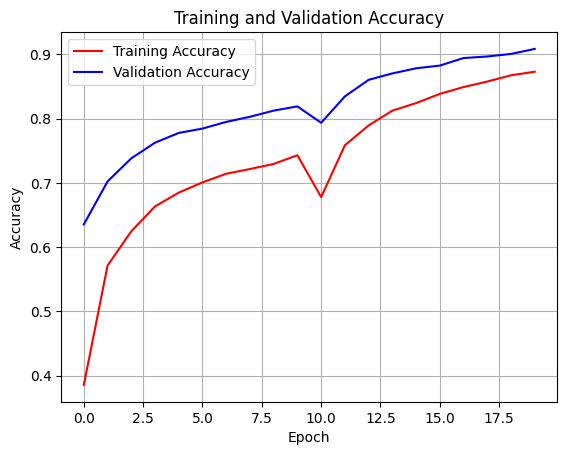

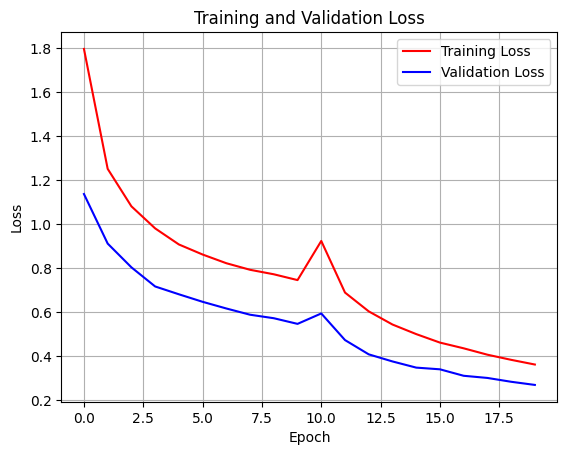

In [ ]:
# Gabungkan history dari 3 tahap
combined_acc = (
    history.history['accuracy'] +
    fine_tune_history.history['accuracy'] +
    fine_tune_history_2.history['accuracy']
)

combined_val_acc = (
    history.history['val_accuracy'] +
    fine_tune_history.history['val_accuracy'] +
    fine_tune_history_2.history['val_accuracy']
)

combined_loss = (
    history.history['loss'] +
    fine_tune_history.history['loss'] +
    fine_tune_history_2.history['loss']
)

combined_val_loss = (
    history.history['val_loss'] +
    fine_tune_history.history['val_loss'] +
    fine_tune_history_2.history['val_loss']
)

epochs = range(len(combined_acc))

# Plot akurasi
plt.plot(epochs, combined_acc, 'r', label='Training Accuracy')
plt.plot(epochs, combined_val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.plot(epochs, combined_loss, 'r', label='Training Loss')
plt.plot(epochs, combined_val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 253ms/step


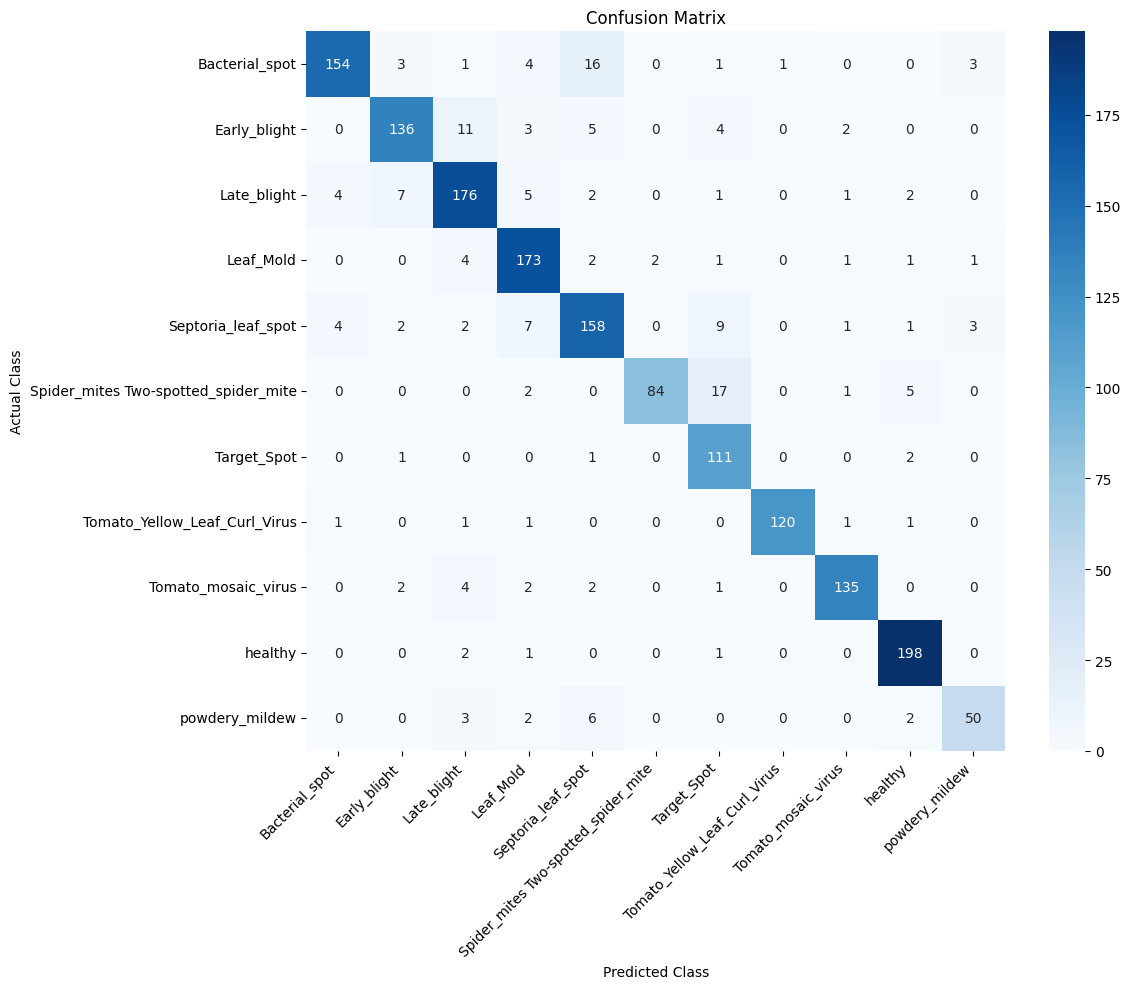


Classification Report:

                                      precision    recall  f1-score   support

                      Bacterial_spot     0.9448    0.8415    0.8902       183
                        Early_blight     0.9007    0.8447    0.8718       161
                         Late_blight     0.8627    0.8889    0.8756       198
                           Leaf_Mold     0.8650    0.9351    0.8987       185
                  Septoria_leaf_spot     0.8229    0.8449    0.8338       187
Spider_mites Two-spotted_spider_mite     0.9767    0.7706    0.8615       109
                         Target_Spot     0.7603    0.9652    0.8506       115
       Tomato_Yellow_Leaf_Curl_Virus     0.9917    0.9600    0.9756       125
                 Tomato_mosaic_virus     0.9507    0.9247    0.9375       146
                             healthy     0.9340    0.9802    0.9565       202
                      powdery_mildew     0.8772    0.7937    0.8333        63

                            accuracy 

In [ ]:
# Reset generator dan prediksi
test_generator.reset()
pred_probs = model.predict(test_generator, verbose=1)
preds = np.argmax(pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(test_generator.classes, preds)
class_labels = list(test_generator.class_indices.keys())

# Plot confusion matrix heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:\n")
print(classification_report(test_generator.classes, preds, target_names=class_labels, digits=4))

#### **Interpretasi**

Model klasifikasi citra daun berhasil mencapai **akurasi keseluruhan sebesar 89.31%**, yang menunjukkan performa cukup baik dalam mengenali 10 kelas penyakit dan 1 kelas kondisi daun sehat.

Secara umum, model menunjukkan **precision dan recall tinggi** pada sebagian besar kelas. Kelas seperti `Tomato_Yellow_Leaf_Curl_Virus`, `Tomato_mosaic_virus`, dan `Healthy` memiliki skor f1 di atas 0.93, menunjukkan prediksi yang sangat baik. Sebaliknya, kelas `Spider_mites` dan `Powdery_mildew` memiliki nilai recall yang lebih rendah (masing-masing 77.06% dan 79.37%), mengindikasikan masih ada kesalahan dalam mendeteksi kelas tersebut.

Confusion matrix memperlihatkan bahwa sebagian besar prediksi benar berada pada diagonal utama, dengan beberapa kesalahan prediksi yang terjadi antar kelas dengan gejala mirip, seperti `Bacterial_spot`, `Septoria_leaf_spot`, dan `Early_blight`.

Rata-rata skor makro dan tertimbang dari precision, recall, dan f1-score berada di atas 88%, menandakan performa yang konsisten di berbagai kelas.

## **Konversi Model**

**Simpan ke Format SavedModel**

In [ ]:
model.save('model.keras')

**Konversi dan Simpan ke TensorFlow Lite**

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
tflite_model = converter.convert()

with open('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

labels = list(train_generator.class_indices.keys())  # Ambil label dari generator
with open('tflite/label.txt', 'w') as f:
    f.write('\n'.join(labels))

**Konversi dan Simpan ke TensorFlow.js**

In [ ]:
!tensorflowjs_converter --input_format=tf_saved_model saved_model tfjs_model

## **Inference**

Inference adalah proses menggunakan model yang telah dilatih untuk membuat prediksi terhadap data baru.
Pada tahap ini, model terbaik hasil pelatihan (`best_model.h5`) dimuat dan digunakan untuk memprediksi jenis penyakit pada daun tomat dari gambar yang diunggah oleh pengguna. Gambar diproses agar sesuai dengan input model, lalu dilakukan prediksi dan ditampilkan hasilnya berupa nama kelas penyakit beserta tingkat kepercayaan. Hasil prediksi divisualisasikan langsung bersama gambar yang diunggah.


In [10]:
# Load model
model = load_model('best_model.h5')

# Kelas prediksi (sesuai urutan label di training)
class_labels = [
    'Bacterial Spot',
    'Early Blight',
    'Late Blight',
    'Leaf Mold',
    'Septoria Leaf Spot',
    'Spider Mites / Two-Spotted Spider Mite',
    'Target Spot',
    'Tomato Yellow Leaf Curl Virus',
    'Tomato Mosaic Virus',
    'Healthy',
    'Powdery Mildew'
]

In [13]:
# Fungsi prediksi gambar
def predict_uploaded_image(image_path, model, class_labels, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    predicted_class = class_labels[np.argmax(predictions)]
    confidence = np.max(predictions)
    return predicted_class, confidence

Saving Gls6_hight.jpg to Gls6_hight.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


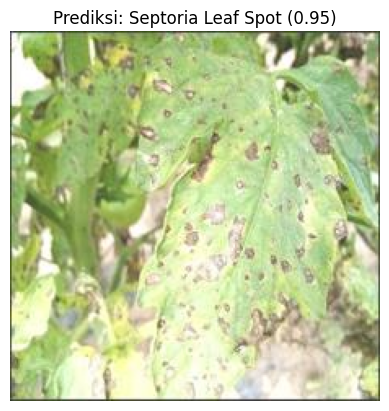

Gambar: Gls6_hight.jpg
Prediksi: Septoria Leaf Spot (Confidence: 0.95)



In [35]:
# Upload gambar dari lokal
uploaded = files.upload()

# Prediksi & visualisasi untuk setiap gambar
for filename in uploaded.keys():
    try:
        predicted_class, confidence = predict_uploaded_image(filename, model, class_labels)

        img = mpimg.imread(filename)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Prediksi: {predicted_class} ({confidence:.2f})")
        plt.show()

        print(f"Gambar: {filename}")
        print(f"Prediksi: {predicted_class} (Confidence: {confidence:.2f})\n")

    except Exception as e:
        print(f"Gagal memproses {filename}: {e}")